<a href="https://colab.research.google.com/github/farsim-hossain/python-projects/blob/main/Basic_Regression_Predict_Fuel_Efficiency_with_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Fuel Eficiency

We wil use Auto MPG dataset and build a model to predict the fuel efficiency of late 1970 and 1980 automobiles. 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

Lets set how numpy will give us a friendly looking display.

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf 

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing 

print(tf.__version__)

2.4.1


## Getting the data

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names= column_names, na_values = '?',comment = '\t', sep =' ', skipinitialspace=True )

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Cleaning the data

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

We need to convert the origin column with its respective origin country names

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns = ['Origin'], prefix = '',prefix_sep='')

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Train test split

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data

Lets get a brief overview of the columns.

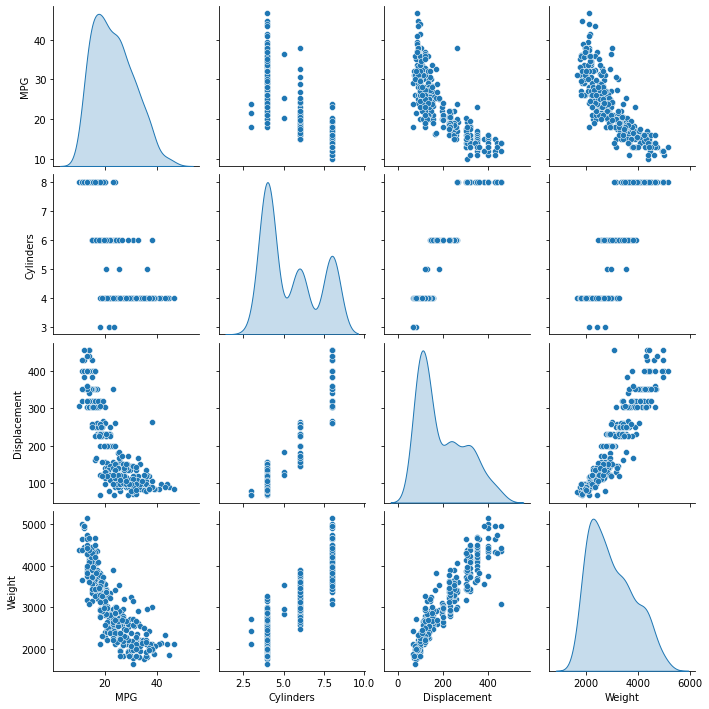

In [10]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split Features from Labels

Lets seperate the MPG column from train and test sets.

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization
Lets add a normalization layer.

In [13]:
normalizer = preprocessing.Normalization()

Then adapt it to the data.

In [14]:
normalizer.adapt(np.array(train_features))

Lets see how the normalizer layer normalized the actual values. We will see a result of two arrays, first the actual values and then the normalized ones.

In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision =2, suppress = True):
  print('First Example:', first)
  print('Normalized:', normalizer(first).numpy())

First Example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear Regression 

Lets start with a single variable regression which predicts MPG from horsepower. In this case, we have to normalize the Horpospower column.

In [17]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

## Building the Sequential Model

In [18]:
horsepower_model = tf.keras.Sequential([horsepower_normalizer,layers.Dense(units = 1)])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Lets run this on the first ten horsepower values. 

In [19]:
horsepower_model.predict(horsepower[:10])

array([[ 0.157],
       [ 0.089],
       [-0.289],
       [ 0.22 ],
       [ 0.199],
       [ 0.078],
       [ 0.236],
       [ 0.199],
       [ 0.052],
       [ 0.089]], dtype=float32)

Once the model is built, configure the training procedure using the Model.compile() method. The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam)

In [20]:
horsepower_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error'
)

Once the training is configured, use Model.fit() to execute the training:

In [21]:
%%time 

history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 9 s, sys: 224 ms, total: 9.23 s
Wall time: 9.13 s


Visualize the model's training progress using the stats stored in the history object.

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.805243,4.211030,95
96,3.803576,4.194285,96
97,3.802873,4.188863,97
98,3.803651,4.183259,98
99,3.803691,4.191201,99


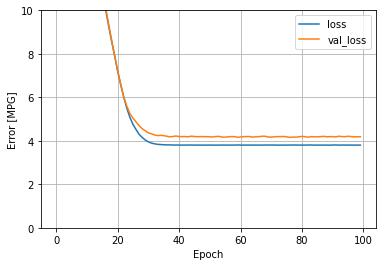

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history) 

Collect the results on teh test set for later

In [28]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose =0
)

## Making a sample prediction and visualize.



In [30]:
# defining samples 

x = tf.linspace(0.0, 250, 251)
y= horsepower_model.predict(x)

In [32]:
def plot_horsepower(x,y):
  plt.scatter(train_features['Horsepower'],train_labels,label ='Sample Data')
  plt.plot(x,y, color = 'k', label = 'Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

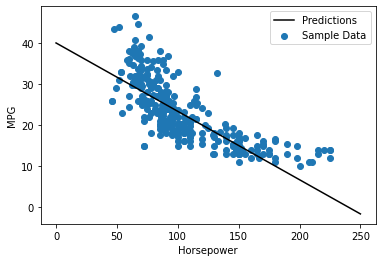

In [33]:
plot_horsepower(x,y)

## Multiple Inputs 

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same  except that  is a matrix and  is a vector.

This time use the Normalization layer that was adapted to the whole dataset.

In [34]:
linear_model = tf.keras.Sequential([
                                    normalizer,
                                    layers.Dense(units =1)
])

In [35]:
# predict on batch of inputs 

linear_model.predict(train_features[:10])

array([[-0.67 ],
       [ 0.607],
       [ 1.27 ],
       [ 0.161],
       [ 0.512],
       [ 1.044],
       [ 0.477],
       [-1.227],
       [ 0.607],
       [-0.034]], dtype=float32)

We know that there are weight matrcies in the model. Lets see the weights.

In [36]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.639],
       [-0.54 ],
       [ 0.026],
       [ 0.741],
       [ 0.292],
       [ 0.411],
       [-0.553],
       [ 0.562],
       [ 0.603]], dtype=float32)>

In [38]:
## Compiling and fitting the model

linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error'
)

In [39]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs = 100,
    verbose =0,
    validation_split = 0.2
)

CPU times: user 8.75 s, sys: 193 ms, total: 8.94 s
Wall time: 8.69 s


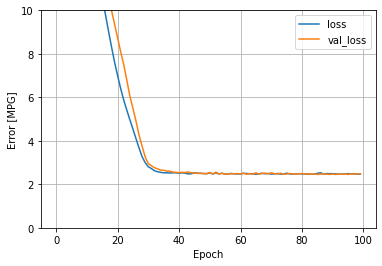

In [41]:
## lets visualize whether the validation loss is less or atleast equal to train set or not

plot_loss(history)

collect the results on the test for later

In [42]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose =0
)

## DNN regression with magic hidden layers 

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

The normalization layer.
Two hidden, nonlinear, Dense layers using the relu nonlinearity.
A linear single-output layer.
Both will use the same training procedure so the compile method is included in the build_and_compile_model function below.



In [43]:
def build_and_compile_model(norm):
  model = keras.Sequential([
                            norm,
                            layers.Dense(64, activation = 'relu'),
                            layers.Dense(64, activation = 'relu'),
                            layers.Dense(1)

                          
  ])

  model.compile(loss= 'mean_absolute_error',
              optimizer = tf.keras.optimizers.Adam(0.001))

  return model

## Checking with a single variable 



In [44]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer) #giving normalized inputs to the model

In [45]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


## Train the model 

In [46]:
%%time 

history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split = 0.2,
    verbose = 0, epochs = 100
)

CPU times: user 9.35 s, sys: 236 ms, total: 9.59 s
Wall time: 9.21 s


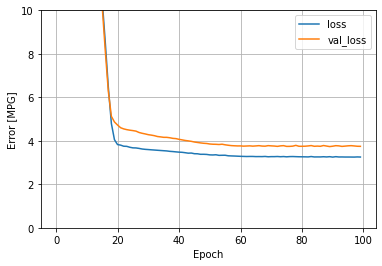

In [47]:
## check the validation loss 
plot_loss(history)

## Check with the sample inputs

Hopefully this model will be much better because of its **hidden* layers

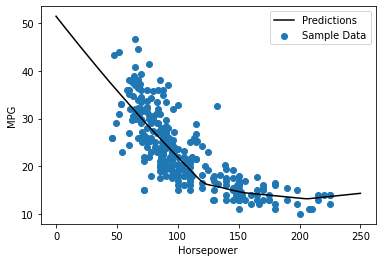

In [48]:
x = tf.linspace(0.0,250,251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x,y)

## BEAUTIFUL !! 

lets collect the result on the test set.

In [50]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose =0
)

## Full Model ! 

Lets use the build and compile model function

In [51]:
dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [52]:
%%time

history = dnn_model.fit(
    train_features, train_labels,
    validation_split = 0.2,
    verbose = 0, epochs = 100
)

CPU times: user 9.15 s, sys: 232 ms, total: 9.38 s
Wall time: 8.99 s


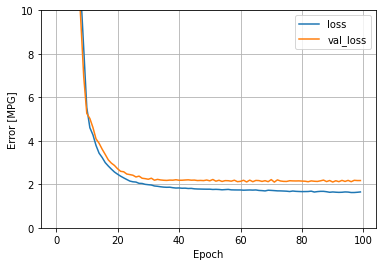

In [53]:
plot_loss(history)

## Collecting the results on the test set

In [54]:
test_results['dnn_model'] = dnn_model.evaluate(
    test_features, test_labels, verbose =0
)

## Performance of all models

In [55]:
pd.DataFrame(test_results, index = ['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.653956
linear_model,2.495996
dnn_horsepower_model,2.941418
dnn_model,1.702476


Looks like the dnn model have the least error

## Make Predictions



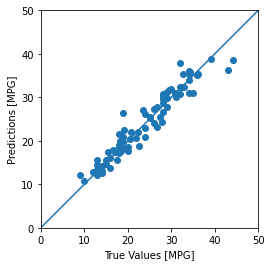

In [58]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect = 'equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims,lims)
#plt.show()

Looks like the model performed reasonably well.

Text(0, 0.5, 'Count')

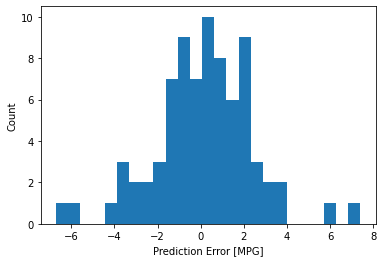

In [59]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')



In [60]:
# Lets save the model
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If we reload the model, it will give identical output

In [62]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose =0)

pd.DataFrame(test_results, index = ['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.653956
linear_model,2.495996
dnn_horsepower_model,2.941418
dnn_model,1.702476
reloaded,1.702476
